<img align="left" src="imgs/logo.jpg" width="50px" style="margin-right:10px">

# Snorkel Workshop: Extracting Spouse Relations from the News
## Advanced Part 6:  Hyperparameter Tuning via Grid Search


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import numpy as np

# Connect to the database backend and initalize a Snorkel session
from lib.init import *

We repeat our definition of the `Spouse` `Candidate` subclass, and load the test set:

In [2]:
Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

# I. Training a `SparseLogisticRegression` Discriminative Model
We use the training marginals to train a discriminative model that classifies each `Candidate` as a true or false mention. We'll use a random hyperparameter search, evaluated on the development set labels, to find the best hyperparameters for our model. To run a hyperparameter search, we need labels for a development set. If they aren't already available, we can manually create labels using the Viewer.

## Feature Extraction
Instead of using a deep learning approach to start, let's look at a standard sparse logistic regression model. First, we need to extract out features. This can take a while, but we only have to do it once!

In [3]:
from lib.features import hybrid_span_mention_ftrs
from snorkel.annotations import FeatureAnnotator

featurizer = FeatureAnnotator(f=hybrid_span_mention_ftrs)

In [4]:
F_train = featurizer.load_matrix(session, split=0)
F_dev   = featurizer.load_matrix(session, split=1)
F_test  = featurizer.load_matrix(session, split=2)

if F_train.size == 0:    
    %time F_train = featurizer.apply(split=0, parallelism=1)
if F_dev.size == 0:     
    %time F_dev  = featurizer.apply_existing(split=1, parallelism=1)
if F_test.size == 0:
    %time F_test = featurizer.apply_existing(split=2, parallelism=1)

print(F_train.shape)
print(F_dev.shape)
print(F_test.shape)

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 10min 7s, sys: 36.5 s, total: 10min 44s
Wall time: 16min 16s
Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 2min, sys: 7.4 s, total: 2min 8s
Wall time: 3min 14s
Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 47s, sys: 6.97 s, total: 1min 54s
Wall time: 2min 57s
(16672, 240337)
(2245, 240337)
(1949, 240337)




First, reload the training marginals:

In [5]:
from snorkel.annotations import load_marginals
train_marginals = load_marginals(session, split=0)

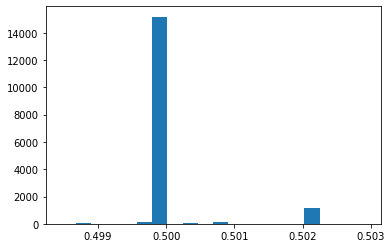

In [6]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

Load our development data for tuning

In [7]:
from snorkel.annotations import load_gold_labels

L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev.shape

(2245, 1)

The following code performs model selection by tuning our learning algorithm's hyperparamters. **_Note: This requires installing tensorflow: `conda install tensorflow`._**

In [8]:
from snorkel.learning import RandomSearch
from snorkel.learning.tensorflow import SparseLogisticRegression

seed = 1234
num_model_search = 5

# search over this parameter grid
param_grid = {}
param_grid['batch_size'] = [64, 128]
param_grid['lr']         = [1e-4, 1e-3, 1e-2]
param_grid['l1_penalty'] = [1e-6, 1e-4, 1e-2]
param_grid['l2_penalty'] = [1e-6, 1e-4, 1e-2]
param_grid['rebalance']  = [0.0, 0.5]

model_class_params = {
    'n_threads':1
}

model_hyperparams = {
    'n_epochs': 30,
    'print_freq': 10,
    'dev_ckpt_delay': 0.5,
    'X_dev': F_dev,
    'Y_dev': L_gold_dev
}

searcher = RandomSearch(SparseLogisticRegression, param_grid, F_train, train_marginals,
                        n=num_model_search, seed=seed,
                        model_class_params=model_class_params,
                        model_hyperparams=model_hyperparams)

print("Discriminitive Model Parameter Space (seed={}):".format(seed))
for i, params in enumerate(searcher.search_space()):
    print("{} {}".format(i, params))

disc_model, run_stats = searcher.fit(X_valid=F_dev, Y_valid=L_gold_dev, n_threads=1)
run_stats

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Discriminitive Model Parameter Space (seed=1234):
0 (128, 0.0001, 0.01, 0.01, 0.0)
1 (128, 0.0001, 0.01, 0.01, 0.5)
2 (64, 0.001, 0.01, 0.01, 0.0)
3 (128, 0.001, 1e-06, 1e-06, 0.5)
4 (64, 0.001, 1e-06, 1e-06, 0.5)
[1] Testing batch_size = 64, lr = 1.00e-04, l1_penalty = 1.00e-06, l2_penalty = 1.00e-04, rebalance = 0.00e+00





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[SparseLogisticRegression] Training model
[SparseLogisticRegression] n_train=1495  #epochs=30  batch size=64
[SparseLogisticRegression] Epoch 0 (0.92s)	Average loss=0.947900	Dev F1=9.33
[SparseLogisticRegressio

[SparseLogisticRegression] F-1 Score: 0.08659217877094971
INFO:tensorflow:Restoring parameters from checkpoints/grid_search/SparseLogisticRegression_1/SparseLogisticRegression_1-0
[SparseLogisticRegression] Loaded model <SparseLogisticRegression_1>


,batch_size,lr,l1_penalty,l2_penalty,rebalance,Prec.,Rec.,F-1
1,64,0.0010,0.000100,0.010000,0.5,0.054098,0.653465,0.099924
2,128,0.0100,0.000001,0.000100,0.0,0.052232,0.544554,0.095321
3,64,0.0100,0.010000,0.010000,0.0,0.050032,0.782178,0.094048
0,64,0.0001,0.000001,0.000100,0.0,0.047377,0.554455,0.087295
4,64,0.0100,0.000001,0.000001,0.5,0.046582,0.613861,0.086592


## Examining Features
Extracting features allows us to inspect and interperet our learned weights 

In [9]:
from lib.scoring import *
print_top_k_features(session, disc_model, F_train, top_k=25)

240337
[-0.2692288, 'BETWEEN_SEQ_POS_TAGS[RBS JJ]']
[-0.26609722, 'BETWEEN_LEMMAS[lower]']
[-0.25545013, 'BETWEEN_SEQ_LEMMAS[length dress ,]']
[-0.25052166, 'WIN_RIGHT_LEMMAS[surprised]']
[-0.23814753, 'WIN_RIGHT_SEQ_LEMMAS[be arrest Saturday]']
[-0.235447, 'BETWEEN_SEQ_LEMMAS[legend of the]']
[-0.23506752, 'WIN_LEFT_SEQ_LEMMAS[suggest a]']
[-0.23383911, 'WIN_RIGHT_SEQ_LEMMAS[36 .]']
[-0.23379186, 'WIN_LEFT_SEQ_LEMMAS[actress and -PRON-]']
[-0.23231317, 'BETWEEN_SEQ_LEMMAS[term , -PRON-]']
[-0.2306268, 'WIN_LEFT_SEQ_POS_TAGS[NN , VBP]']
[-0.22970876, 'BETWEEN_SEQ_LEMMAS[del Sol]']
[-0.2288735, 'BETWEEN_LEMMAS[Duncan]']
[-0.22881396, 'WIN_LEFT_LEMMAS[favourite]']
[-0.22490391, 'BETWEEN_SEQ_LEMMAS[attend high school]']
[-0.22469394, 'WIN_RIGHT_SEQ_LEMMAS[Rigby )]']
[-0.22425845, 'WIN_LEFT_SEQ_LEMMAS[ok , but]']
[-0.22380868, 'BETWEEN_SEQ_LEMMAS[Western Region Chief]']
[-0.22208485, 'WIN_RIGHT_SEQ_LEMMAS[certainly think so]']
[-0.2164961, 'BETWEEN_SEQ_LEMMAS[a court to]']
[-0.2158836, 'WI